# VARMAX models

This is a brief introduction notebook to VARMAX models in statsmodels. The VARMAX model is generically specified as:
$$
y_t = \nu + A_1 y_{t-1} + \dots + A_p y_{t-p} + B x_t + \epsilon_t +
M_1 \epsilon_{t-1} + \dots M_q \epsilon_{t-q}
$$

where $y_t$ is a $\mathrm{k_endog} \times 1$ vector.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [3]:
import shutil

import requests


def download_file(url):
    local_filename = url.split("/")[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, "wb") as f:
            shutil.copyfileobj(r.raw, f)

    return local_filename


filename = download_file("https://www.stata-press.com/data/r12/lutkepohl2.dta")

dta = pd.read_stata(filename)
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc["1960-04-01":"1978-10-01", ["dln_inv", "dln_inc", "dln_consump"]]

## Model specification

The `VARMAX` class in statsmodels allows estimation of VAR, VMA, and VARMA models (through the `order` argument), optionally with a constant term (via the `trend` argument). Exogenous regressors may also be included (as usual in statsmodels, by the `exog` argument), and in this way a time trend may be added. Finally, the class allows measurement error (via the `measurement_error` argument) and allows specifying either a diagonal or unstructured innovation covariance matrix (via the `error_cov_type` argument).

## Example 1: VAR

Below is a simple VARX(2) model in two endogenous variables and an exogenous series, but no constant term. Notice that we needed to allow for more iterations than the default (which is `maxiter=50`) in order for the likelihood estimation to converge. This is not unusual in VAR models which have to estimate a large number of parameters, often on a relatively small number of time series: this model, for example, estimates 27 parameters off of 75 observations of 3 variables.

In [4]:
exog = endog["dln_consump"]
mod = sm.tsa.VARMAX(endog[["dln_inv", "dln_inc"]], order=(2, 0), trend="n", exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                            VARX(2)   Log Likelihood                 361.032
Date:                    Fri, 19 Sep 2025   AIC                           -696.063
Time:                            10:21:01   BIC                           -665.936
Sample:                        04-01-1960   HQIC                          -684.033
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.03, 10.27   Jarque-Bera (JB):          10.97, 2.38
Prob(Q):                        0.86, 0.00   Prob(JB):                   0.00, 0.30
Heteroskedasticity (H):         0.45, 0.40   Skew:                      0.15, -0.38
Prob(H) (two-sided):            0.05, 0.02   Kurtosis:                   4.85, 3.44


From the estimated VAR model, we can plot the impulse response functions of the endogenous variables.

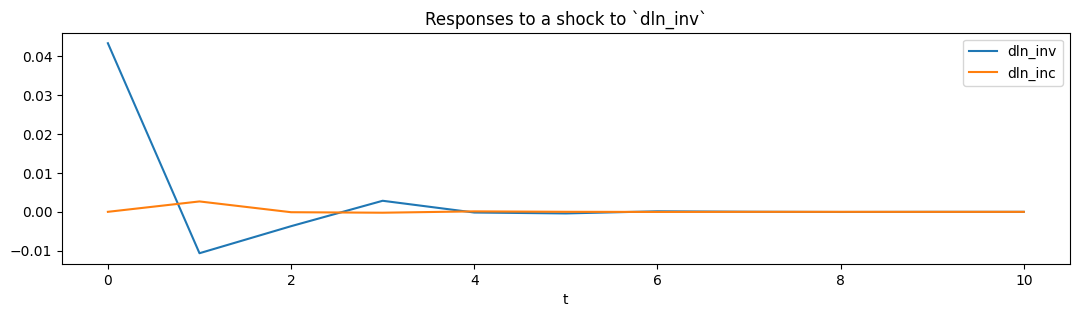

In [5]:
ax = res.impulse_responses(10, orthogonalized=True, impulse=[1, 0]).plot(
    figsize=(13, 3)
)
ax.set(xlabel="t", title="Responses to a shock to `dln_inv`");

## Example 2: VMA

A vector moving average model can also be formulated. Below we show a VMA(2) on the same data, but where the innovations to the process are uncorrelated. In this example we leave out the exogenous regressor but now include the constant term.

In [6]:
mod = sm.tsa.VARMAX(
    endog[["dln_inv", "dln_inc"]], order=(0, 2), error_cov_type="diagonal"
)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                             VMA(2)   Log Likelihood                 353.880
                              + intercept   AIC                           -683.761
Date:                    Fri, 19 Sep 2025   BIC                           -655.951
Time:                            10:21:29   HQIC                          -672.656
Sample:                        04-01-1960                                         
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.00, 0.04   Jarque-Bera (JB):         13.44, 14.28
Prob(Q):                        1.00, 0.84   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.44, 0.81   Skew:                      0.07, -0.49
P

## Caution: VARMA(p,q) specifications

Although the model allows estimating VARMA(p,q) specifications, these models are not identified without additional restrictions on the representation matrices, which are not built-in. For this reason, it is recommended that the user proceed with error (and indeed a warning is issued when these models are specified). Nonetheless, they may in some circumstances provide useful information.

In [7]:
mod = sm.tsa.VARMAX(endog[["dln_inv", "dln_inc"]], order=(1, 1))
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                         VARMA(1,1)   Log Likelihood                 354.288
                              + intercept   AIC                           -682.576
Date:                    Fri, 19 Sep 2025   BIC                           -652.448
Time:                            10:21:30   HQIC                          -670.546
Sample:                        04-01-1960                                         
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.00, 0.06   Jarque-Bera (JB):         11.14, 14.18
Prob(Q):                        0.95, 0.81   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.43, 0.91   Skew:                      0.01, -0.46
P